### exp: eqtl prediction, sign prediction, hyena for machine learning

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
model_size = ['small','middle','large']
model_list = ['xgboost','lightgbm','random forest','knn','svm']
tissue = 'Nerve_Tibial'
data_path = '../../../../../datasets_embedding/hyena/eqtl_datasets/sign_prediction/' + tissue + '/'
image_path = 'images_shuffled_seed510/'
# set seed
seed = 510
import random
random.seed(seed)
np.random.seed(seed)

#### small model

In [4]:
model = model_size[0]
train_data = pd.read_pickle(data_path + 'hyena_' +  model +  '_train.dataset')
valid_data = pd.read_pickle(data_path + 'hyena_' +  model +  '_valid.dataset')
test_data = pd.read_pickle(data_path + 'hyena_' +  model +  '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['hyena_before'][i].flatten().tolist()
    feature_list += train_data['hyena_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['hyena_before'][i].flatten().tolist()
    feature_list += test_data['hyena_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id             variant_id  tss_distance       maf  \
0   ENSG00000242485.5   chr1_1407232_G_C_b38           -81  0.182648   
1  ENSG00000157881.13   chr1_2526571_G_C_b38           -57  0.020548   
2   ENSG00000231789.2   chr1_9687685_C_T_b38           130  0.043379   
3   ENSG00000272084.1  chr1_19075748_C_A_b38           237  0.109589   
4   ENSG00000090432.6  chr1_20508117_C_A_b38           -44  0.110599   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0        147      160  3.926291e-46  0.436504  0.026472      1   
1         17       18  5.059731e-09  0.500525  0.083591      1   
2         36       38  1.409246e-08  0.738330  0.127241      1   
3         91       96  7.632423e-09  0.404185  0.068344      1   
4         93       96  3.275938e-73  0.996535  0.043319      1   

                                          seq_before  \
0  gcactccagcctgggtgacagcgcgagactccgtctcggggtaaga...   
1  cgaaaagggagtaattcgcgttcctcccctagaggtggctgggagg...   
2 

In [5]:
print(train_data['label'].unique())

[0 1]


##### model 1: xgboost

In [6]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': np.int64(10)}
{'max_depth': np.int64(9)}


accuracy:0.6086956521739131
precision:0.6521739130434783
recall:0.6
f1-score:0.625


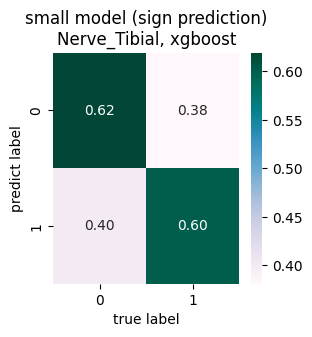

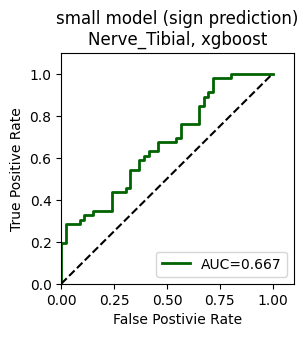

In [7]:
ml_model = model_list[0]
clf_xgb = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [8]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': np.int64(17)}
{'num_leaves': np.int64(26)}


accuracy:0.6521739130434783
precision:0.6666666666666666
recall:0.72
f1-score:0.6923076923076923


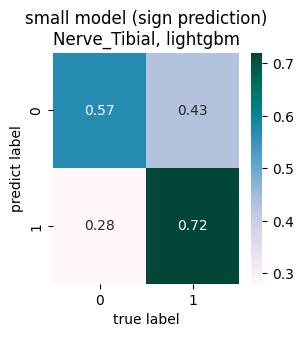

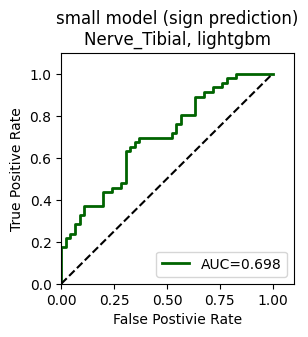

In [9]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMClassifier(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_score = clf_lgb.predict(X_test)                                   
y_score_pro = clf_lgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': np.int64(10)}
{'max_depth': np.int64(2)}


accuracy:0.5217391304347826
precision:0.5428571428571428
recall:0.76
f1-score:0.6333333333333333


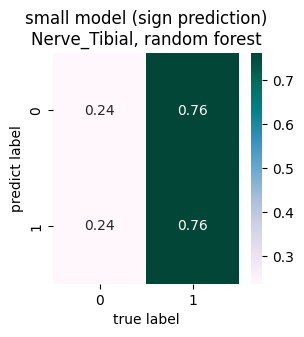

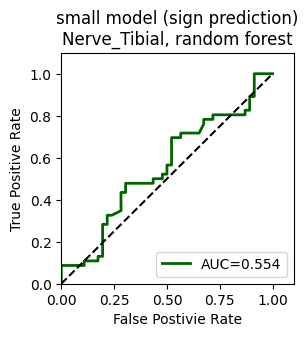

In [11]:
ml_model = model_list[2]
clf_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_score = clf_rf.predict(X_test)                                   
y_score_pro = clf_rf.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': np.int64(300)}

accuracy:0.5434782608695652
precision:0.5434782608695652
recall:1.0
f1-score:0.704225352112676


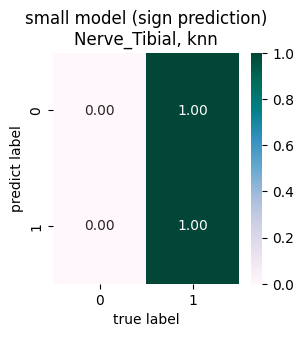

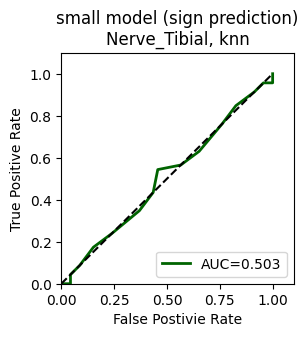

In [13]:
ml_model = model_list[3]
clf_knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_score = clf_knn.predict(X_test)                                   
y_score_pro = clf_knn.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 100}
{'C': 0.0001}


accuracy:0.5434782608695652
precision:0.5434782608695652
recall:1.0
f1-score:0.704225352112676


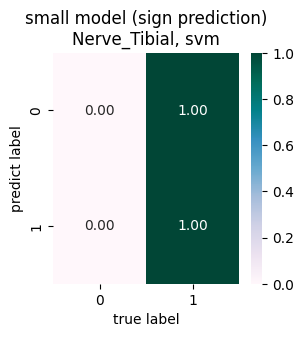

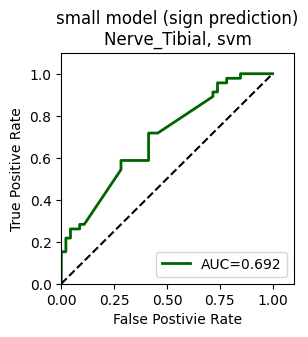

In [15]:
ml_model = model_list[4]
clf_svm = SVC(probability = True, gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_score = clf_svm.predict(X_test)                                   
y_score_pro = clf_svm.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### middle model

In [16]:
model = model_size[1]
train_data = pd.read_pickle(data_path + 'hyena_' +  model +  '_train.dataset')
valid_data = pd.read_pickle(data_path + 'hyena_' +  model +  '_valid.dataset')
test_data = pd.read_pickle(data_path + 'hyena_' +  model +  '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['hyena_before'][i].flatten().tolist()
    feature_list += train_data['hyena_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['hyena_before'][i].flatten().tolist()
    feature_list += test_data['hyena_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id            variant_id  tss_distance       maf  \
0   ENSG00000272512.1   chr1_989148_C_A_b38         -8903  0.455742   
1   ENSG00000272512.1   chr1_999842_C_A_b38          1791  0.444064   
2  ENSG00000008128.22  chr1_1733506_G_A_b38          9182  0.013699   
3  ENSG00000008130.15  chr1_1777680_C_T_b38         -2777  0.076484   
4   ENSG00000182873.5  chr1_2189679_C_T_b38          5290  0.378995   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0        315      400  6.301756e-45  0.753825  0.046540      1   
1        301      389  2.103221e-49  0.757170  0.043822      1   
2         12       12  2.895097e-10  1.414804  0.218233      1   
3         66       67  3.749908e-13  0.248043  0.032905      1   
4        276      332  4.958885e-20  0.558117  0.057414      1   

                                          seq_before  \
0  cttccttttaatgaagtctaatttgcccatttttcttgatgtatta...   
1  cttccttttaatgaagtctaatttgcccatttttcttgatgtatta...   
2  ttcag

##### model 1: xgboost

In [17]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': np.int64(74)}
{'max_depth': np.int64(6)}


accuracy:0.7352941176470589
precision:0.7804878048780488
recall:0.7804878048780488
f1-score:0.7804878048780488


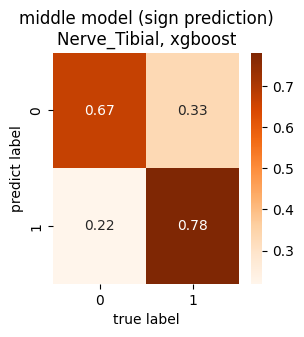

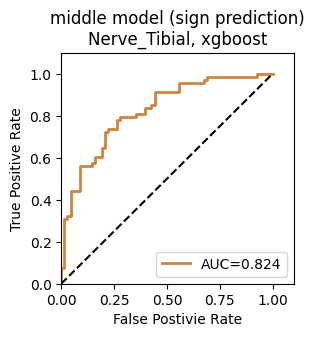

In [18]:
ml_model = model_list[0]
clf_xgb = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [19]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': np.int64(6)}
{'num_leaves': np.int64(26)}


accuracy:0.7352941176470589
precision:0.7948717948717948
recall:0.7560975609756098
f1-score:0.775


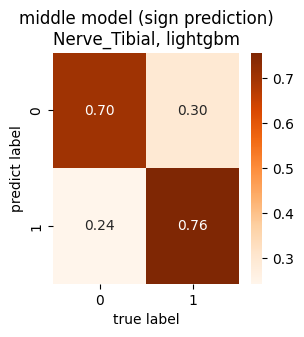

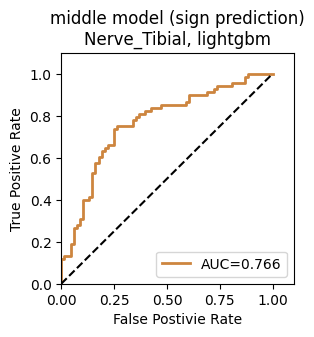

In [20]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMClassifier(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_score = clf_lgb.predict(X_test)                                   
y_score_pro = clf_lgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': np.int64(73)}
{'max_depth': np.int64(9)}


accuracy:0.7058823529411765
precision:0.7692307692307693
recall:0.7317073170731707
f1-score:0.75


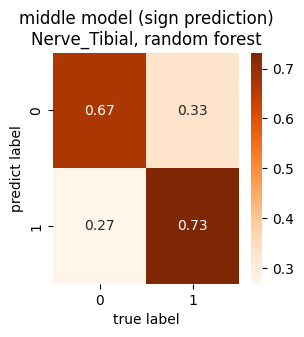

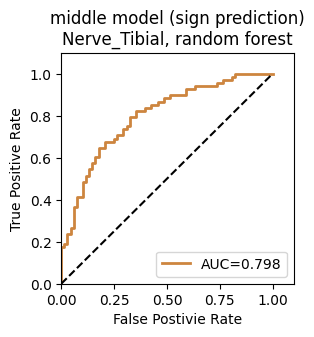

In [22]:
ml_model = model_list[2]
clf_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_score = clf_rf.predict(X_test)                                   
y_score_pro = clf_rf.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': np.int64(100)}

accuracy:0.6176470588235294
precision:0.6829268292682927
recall:0.6829268292682927
f1-score:0.6829268292682927


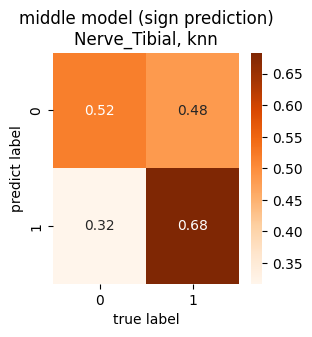

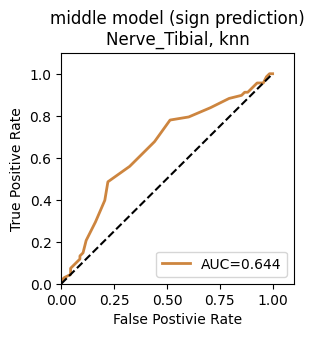

In [24]:
ml_model = model_list[3]
clf_knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_score = clf_knn.predict(X_test)                                   
y_score_pro = clf_knn.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 100}
{'C': 0.01}


accuracy:0.6029411764705882
precision:0.6029411764705882
recall:1.0
f1-score:0.7522935779816514


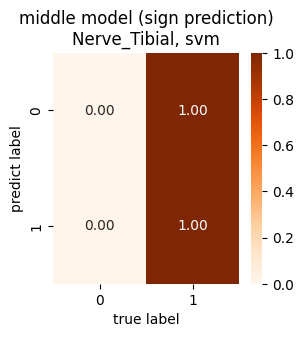

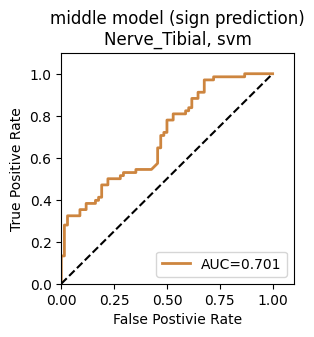

In [26]:
ml_model = model_list[4]
clf_svm = SVC(probability = True, gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_score = clf_svm.predict(X_test)                                   
y_score_pro = clf_svm.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### large model

In [27]:
model = model_size[2]
train_data = pd.read_pickle(data_path + 'hyena_' +  model +  '_train.dataset')
valid_data = pd.read_pickle(data_path + 'hyena_' +  model +  '_valid.dataset')
test_data = pd.read_pickle(data_path + 'hyena_' +  model +  '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['hyena_before'][i].flatten().tolist()
    feature_list += train_data['hyena_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['hyena_before'][i].flatten().tolist()
    feature_list += test_data['hyena_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id            variant_id  tss_distance       maf  \
0   ENSG00000228463.9   chr1_286747_A_G_b38        -10755  0.156393   
1  ENSG00000131591.17  chr1_1091327_C_A_b38        -25034  0.428082   
2   ENSG00000269737.2  chr1_1655861_G_A_b38        -16129  0.033105   
3   ENSG00000227775.3  chr1_1659060_G_A_b38        -65452  0.255760   
4   ENSG00000215790.6  chr1_1733506_G_A_b38        -12486  0.013699   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0        126      137  1.063090e-10  0.577437  0.086836      1   
1        299      375  6.088189e-20  0.226558  0.023370      1   
2         29       29  1.404384e-56  1.941307  0.102178      1   
3        194      224  3.861312e-70  0.909623  0.040866      1   
4         12       12  1.044913e-08  1.295409  0.221167      1   

                                          seq_before  \
0  gagaatcacttgaaccagggaggtggaggttgcagtgtgccaagat...   
1  taatttttgtatttttagtagagatggggtttcatcatgttggcca...   
2  tttca

##### model 1: xgboost

In [28]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': np.int64(106)}
{'max_depth': np.int64(8)}


accuracy:0.6194690265486725
precision:0.6825396825396826
recall:0.6515151515151515
f1-score:0.6666666666666666


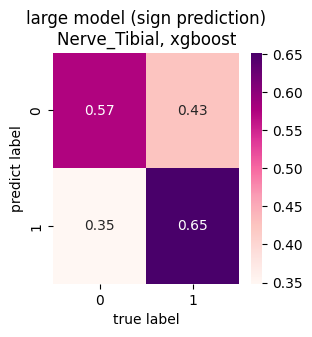

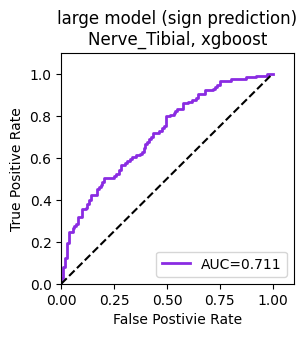

In [29]:
ml_model = model_list[0]
clf_xgb = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [30]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': np.int64(33)}
{'num_leaves': np.int64(26)}


accuracy:0.6283185840707964
precision:0.7
recall:0.6363636363636364
f1-score:0.6666666666666666


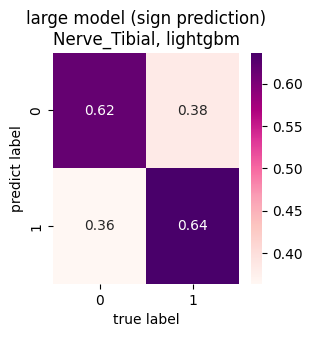

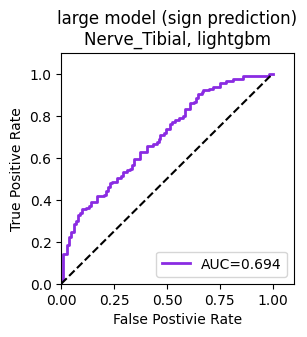

In [31]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMClassifier(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_score = clf_lgb.predict(X_test)                                   
y_score_pro = clf_lgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': np.int64(115)}
{'max_depth': np.int64(10)}


accuracy:0.5752212389380531
precision:0.6607142857142857
recall:0.5606060606060606
f1-score:0.6065573770491803


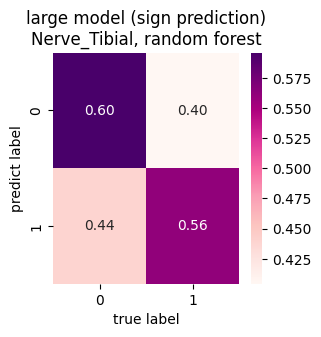

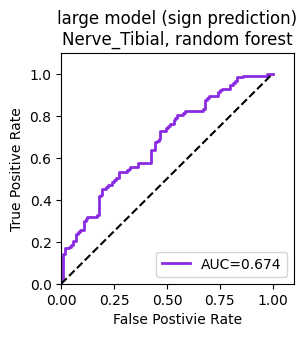

In [33]:
ml_model = model_list[2]
clf_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_score = clf_rf.predict(X_test)                                   
y_score_pro = clf_rf.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': np.int64(122)}

accuracy:0.49557522123893805
precision:0.6
recall:0.4090909090909091
f1-score:0.4864864864864865


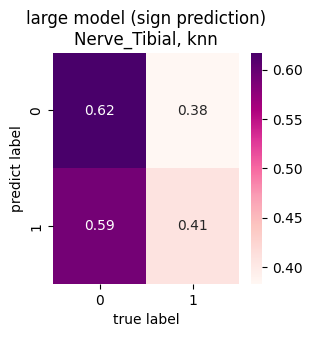

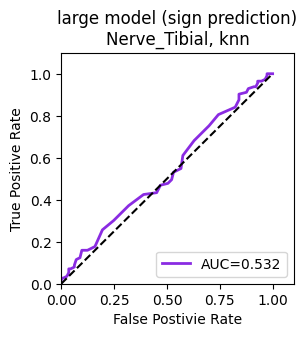

In [35]:
ml_model = model_list[3]
clf_knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_score = clf_knn.predict(X_test)                                   
y_score_pro = clf_knn.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [36]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 1000}
{'C': 1000}


accuracy:0.6371681415929203
precision:0.631578947368421
recall:0.9090909090909091
f1-score:0.7453416149068323


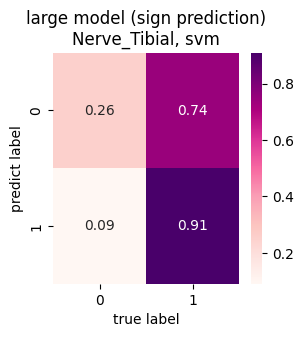

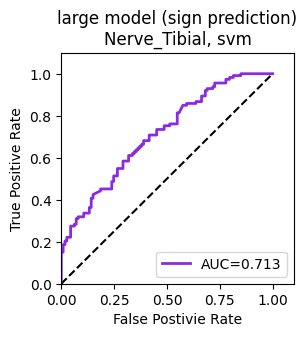

In [37]:
ml_model = model_list[4]
clf_svm = SVC(probability = True, gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_score = clf_svm.predict(X_test)                                   
y_score_pro = clf_svm.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()